## Precompute Features
  
This notebook shows how to compute an initial feature representation (Harmonic Constant-Q Transform or HCQT) from an audio file and how to convert multi-pitch annotations from a csv list of note events to an output representation for training multi-pitch estimators.

&copy; Christof Weiss and Geoffroy Peeters, Télécom Paris 2022

In [1]:
import os
import sys
basepath = os.path.abspath(os.path.dirname(os.path.dirname('.')))
sys.path.append(basepath)
import numpy as np, os, scipy, scipy.spatial, matplotlib.pyplot as plt, IPython.display as ipd
from numba import jit
import librosa
import libfmp.b, libfmp.c3, libfmp.c5
import pandas as pd, pickle, re
from numba import jit
from libdl.data_preprocessing import compute_hopsize_cqt, compute_hcqt, compute_efficient_hcqt, compute_annotation_array_nooverlap

### 1. Load audio

Load an audio file, e.g. from the [MusicNet](https://doi.org/10.5281/zenodo.5139893) dataset. This serves to illustrate the extracted representations and the corresponding pitch annotations.

In [2]:
fs = 22050

audio_folder = os.path.join(basepath, 'data', 'MusicNet', 'audio')
fn_audio = '2382_Beethoven_OP130_StringQuartet.wav'

path_audio = os.path.join(audio_folder, fn_audio)
f_audio, fs_load = librosa.load(path_audio, sr=fs)

### 2. Compute HCQT representation and plot its channels (corresponding to the harmonics)

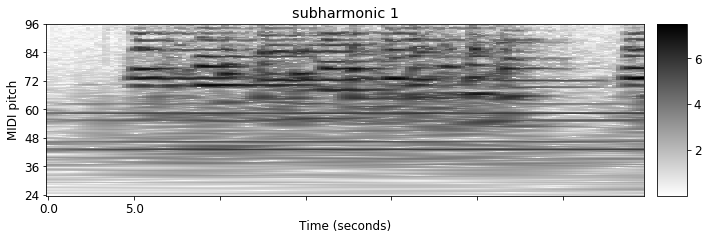

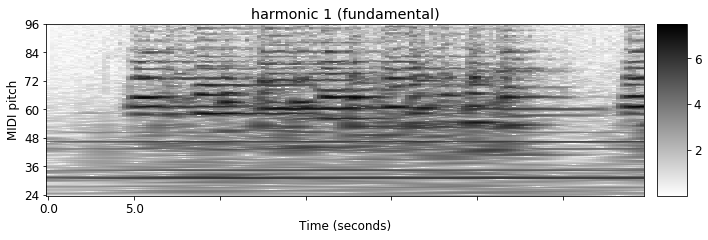

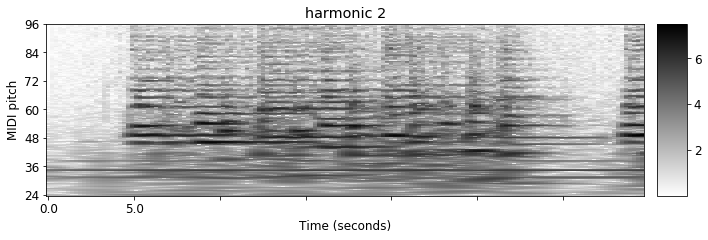

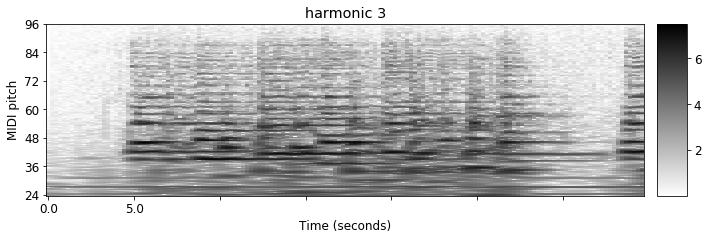

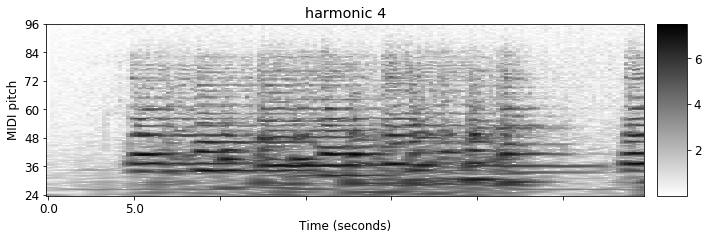

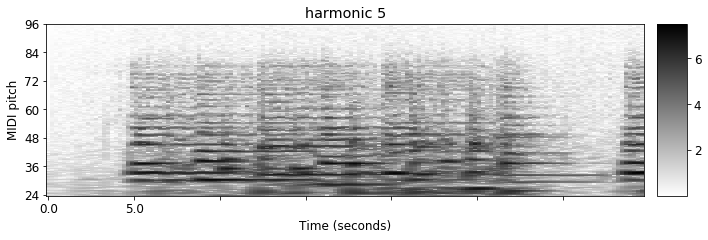

In [3]:
bins_per_semitone = 3
num_octaves = 6
n_bins = bins_per_semitone*12*num_octaves
num_harmonics = 5
num_subharmonics = 1

f_hcqt, fs_hcqt, hopsize_cqt = compute_efficient_hcqt(f_audio, fs=22050, fmin=librosa.note_to_hz('C1'), fs_hcqt_target=50, \
                                                    bins_per_octave=bins_per_semitone*12, num_octaves=num_octaves, \
                                                    num_harmonics=num_harmonics, num_subharmonics=num_subharmonics)

start_sec = 0
show_sec = 3.5

for curr_ax in range(0, 6):
    plt.rcParams.update({'font.size': 12})
    fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 0.05]}, figsize=(10, 3.5))
    im = libfmp.b.plot_matrix(np.log(1+1000*np.abs(f_hcqt[:, int(start_sec*fs_hcqt):int(show_sec*fs_hcqt), curr_ax])), Fs=fs_hcqt, ax=ax, cmap='gray_r', ylabel='MIDI pitch')
    ax[0].set_yticks(np.arange(1, n_bins+13, 12*bins_per_semitone))
    ax[0].set_yticklabels([str(24+12*octave) for octave in range(0, num_octaves+2)])
    ax[0].set_xticklabels(np.arange(start_sec-5, show_sec+5, 5))
    if curr_ax==0:
        ax[0].set_title('subharmonic 1')
    elif curr_ax==1:
        ax[0].set_title('harmonic 1 (fundamental)')
    else:
        ax[0].set_title('harmonic ' + str(curr_ax))
    plt.tight_layout()
    
    
### Optional: Save ###
# path_output = ''
# np.save(os.path.join(path_output, fn_audio[:-4]+'.npy'), f_hcqt)

### 3. Load annotations and convert to numpy array

In [4]:
annot_folder = os.path.join(basepath, 'data', 'MusicNet', 'csv')
fn_annot = os.path.join(annot_folder, fn_audio[:-4]+'.csv')

df = pd.read_csv(fn_annot, sep=',')
note_events = df.to_numpy()[:,(0,1,3)]
note_events[:,:2] /= 44100
note_events = np.append(note_events, np.zeros((note_events.shape[0], 1)), axis=1)
        
f_annot_pitch = compute_annotation_array_nooverlap(note_events.copy(), f_hcqt, fs_hcqt, annot_type='pitch', shorten=1.0)

### 4. Plot annotation array

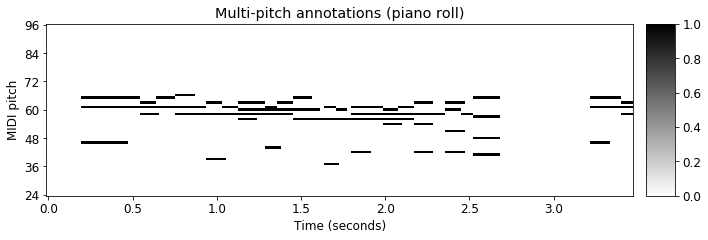

In [5]:
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 0.05]}, figsize=(10, 3.5))

cfig, cax, cim = libfmp.b.plot_matrix(f_annot_pitch[24:97, int(start_sec*fs_hcqt):int(show_sec*fs_hcqt)], ax=ax, Fs=fs_hcqt, cmap='gray_r', ylabel='MIDI pitch')
plt.ylim([0, 73])
ax[0].set_yticks(np.arange(0, 73, 12))
ax[0].set_yticklabels([str(24+12*octave) for octave in range(0, num_octaves+1)])
ax[0].set_title('Multi-pitch annotations (piano roll)')
ax[1].set_ylim([0, 1])
plt.tight_layout()

### Optional: Save ###
# path_output_annot = ''
# np.save(os.path.join(path_output_annot, song_fn_wav[:-4]+'.npy'), f_annot_pitch)

### 5. Plot annotations as overlay to CQT (fundamental), as in Fig. 2 of the paper

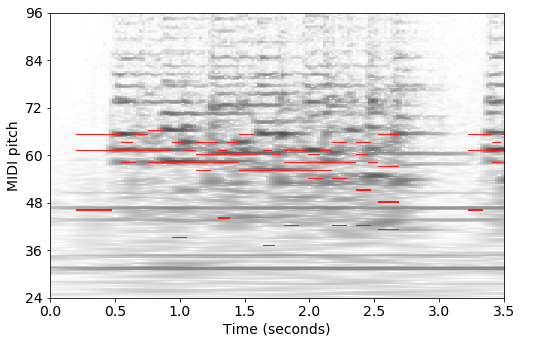

In [6]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 0.05]}, figsize=(8, 5))
f_log = np.log(1+70*np.abs(f_hcqt[:, :, 1]))
f_log /= 0.96*np.max(f_log, axis=None)
im = libfmp.b.plot_matrix(f_log, Fs=fs_hcqt, ax=ax, cmap='gray_r', ylabel='MIDI pitch', clim=[0, 1], colorbar=False)

start_bin = 3*24 # MIDI pitch 24 + centered view
bins_per_semitone = 3
pitch_alpha = np.zeros((f_hcqt.shape[0], f_annot_pitch.shape[1], 4))
for i in range(int((f_hcqt.shape[0]+start_bin)/bins_per_semitone)):
    cqtLine = i*bins_per_semitone - start_bin
    pitch_alpha[cqtLine,:,0:3] = [1, 0.1, 0.1]
    pitch_alpha[cqtLine,:,3] = f_annot_pitch[i,:]*1

T_coef = np.arange(f_hcqt.shape[1]) / fs_hcqt
x_ext1 = (T_coef[1] - T_coef[0]) / 2
x_ext2 = (T_coef[-1] - T_coef[-2]) / 2
ax[0].imshow(pitch_alpha[::-1,:,:], extent=[T_coef[0] - x_ext1, T_coef[-1] + x_ext2, 0, f_hcqt.shape[0]], aspect='auto')
        
ax[0].set_yticks(np.arange(0, n_bins+1, 12*bins_per_semitone))
ax[0].set_yticklabels([str(24+12*octave) for octave in range(0, num_octaves+1)])
ax[0].set_xlim([0, 3.5])

plt.tight_layout()

### Optional: Save ###
# path_output_image = ''
# plt.savefig(path_output_image, dpi=600)